# Window Function on 2D clustering

steps are :
1. Transform the theory cell to the theory omega                               
2.1 Transfrom the window cell to the window omega                               
2.2 Compute the window omega directly with paircounts                             
3. Multiply the theory omega by the window omega
4. Transform back the window-convolved theory omega to cell

In [1]:
## import modules
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
from scipy.optimize import curve_fit
from scipy.interpolate import InterpolatedUnivariateSpline as IUS
from scipy.special import eval_legendre as scipyLeg

In [2]:
plt.rc('font', size=20, family='serif')

In [3]:
def gauleg(ndeg, a=-1.0, b=1.0):
    '''
       Gauss-Legendre (default interval is [-1, 1])
    '''
    x, w = np.polynomial.legendre.leggauss(ndeg)
    # Translate x values from the interval [-1, 1] to [a, b]
    t = 0.5*(x + 1)*(b - a) + a
    w *= 0.5*(b - a)
    return t, w

def xi2cl(x, w, xi, nlmax):
    '''
        calculates Cell from omega
    '''
    cl  = np.zeros(nlmax+1)
    m   = np.arange(nlmax+1)
    for i in m:
        Pl    = np.polynomial.Legendre.basis(i)(x)
        cl[i] = (xi * Pl * w).sum()
    cl *= 2.*np.pi
    return cl

def cl2xi(cl, costheta):
    '''
        calculates omega from Cell at Cos(theta)
    '''
    x     = np.array(costheta)
    l     = np.arange(cl.size)
    coef  = (2*l+1) * cl
    coef *= 0.25/(np.pi)
    y     = np.polynomial.legendre.legval(x, c=coef, tensor=False)
    return y


def apply_window_v0(clth, theta, xiw, theory=True):
    Xiw  = IUS(np.cos(theta), xiw)
    lmax = clth.size-1 
    x,w  = np.polynomial.legendre.leggauss(lmax)
    xith = cl2xi(clth, x)
    xiw  = Xiw(x)
    if theory:
        xif  = xith * xiw
    else:
        xif  = xith / xiw
    
    clf  = xi2cl(x, w, xif, lmax)
    return clf, (x, xif)  


class CellTheory:
    
    def __init__(self, cellfile='/Volumes/TimeMachine/data/mocks/fftloggz0.85redbias2.out'):
        ell_mod, cl_mod = np.loadtxt(cellfile, usecols=(0,1)).T 
        self.lmax = ell_mod.max()
        self.lmin = ell_mod.min()
        print(f'lmin = {self.lmin}')        
        print(f'lmax = {self.lmax}')        
        if self.lmin != 0.0:
            print(f'insert 0.0 for ell=0')
            self.cl_mod = np.insert(cl_mod, 0, 0.0)
        #
        self.params,_ = curve_fit(self._lncl, np.log(ell_mod[-10:]), np.log(cl_mod[-10:]), p0=[1., 0.])
        
    def _lncl(self, lnl, *params):
        return params[0]+lnl*params[1]-(np.exp(lnl)/self.lmax-1.)
                                
    def run(self, ell):
        result = np.array([self.__call__(elli) for elli in ell])
        return result
        
    def __call__(self, ell):
        if ell <= self.lmax:
            return self.cl_mod[ell]
        else:
            return np.exp(self._lncl(np.log(ell), *self.params))

In [4]:
frac = hp.read_map('/Volumes/TimeMachine/data/DR7/frac.hp.256.fits', verbose=False)
mask = hp.read_map('/Volumes/TimeMachine/data/DR7/mask.cut.hp.256.fits', verbose=False) > 0
frac[mask].sum()

179162.1875

In [5]:
(frac[mask]**2).sum()

174639.31640625

## Step 1: Transfor theory Cell to Omega

In [6]:
cl_mod = CellTheory()

lmin = 1.0
lmax = 1000.0
insert 0.0 for ell=0


In [44]:
cl_mod.cl_mod[-5:]

array([4.93883546e-08, 4.93410474e-08, 4.92928852e-08, 4.92442939e-08,
       4.91961642e-08])

transform the theory cell to theory omega

In [7]:
elmax    = 10000
clmod    = cl_mod.run(np.arange(elmax+10))
sep_rad  = np.linspace(0, np.pi, 20*181, endpoint=True)
dsep_rad = np.diff(sep_rad)
cos_sep  = np.cos(sep_rad)
xi_mod   = cl2xi(clmod, cos_sep)

plot cell vs ell, omega vs separation, and cumulative sum of omega vs separation

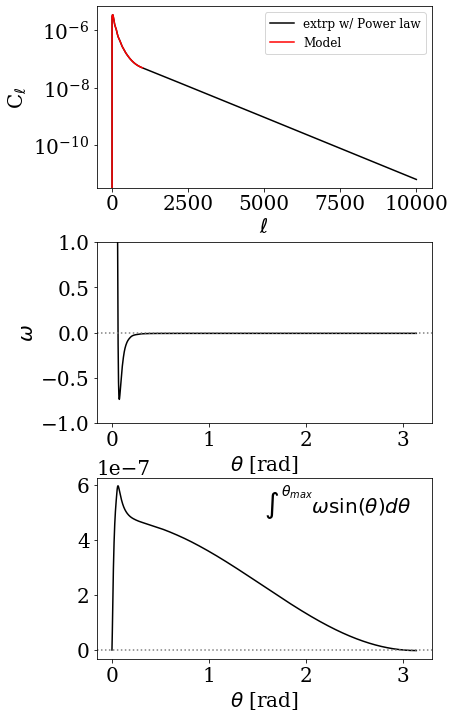

In [8]:
# plot 
fig, ax = plt.subplots(nrows=3, figsize=(6, 12))
fig.subplots_adjust(hspace=0.3)

# ell - cell
ax[0].plot(clmod, 'k', label='extrp w/ Power law')
ax[0].plot(cl_mod.cl_mod, 'r', label='Model')
ax[0].set(ylabel=r'C$_{\ell}$', xlabel=r'$\ell$', yscale='log')
ax[0].legend(fontsize=12)

# theta xi
ax[1].plot(sep_rad, xi_mod/3.0e-5, 'k')
ax[1].axhline(ls=':', color='grey')
ax[1].set(xlabel=r'$\theta$ [rad]', ylabel=r'$\omega$', ylim=(-1, 1))

# theta cumsum(xi)
ax[2].plot(sep_rad[:-1], np.cumsum(np.sin(sep_rad[:-1])*xi_mod[:-1]*dsep_rad), 'k')
ax[2].axhline(ls=':', color='grey')
ax[2].set(xlabel=r'$\theta$ [rad]')
_=ax[2].text(0.5, 0.8, 
             r'$\int^{\theta_{max}}\omega \sin(\theta)d\theta$',
             transform=ax[2].transAxes)

In [9]:
# save 
np.savetxt('./theta_omega_theory.txt', np.column_stack([sep_rad, xi_mod]), header='theta, omega')

## Step 2: Multiply theory omega by window omega

In [10]:
class XiWindow:
    
    def __init__(self, xifile='/Volumes/TimeMachine/data/DR7/dr7_window.cut.256.npy'):
        '''
        '''
        self.totalfrac = 179162.1875
        #self.totalfrac = 174639.31640625
        result   = np.load(xifile, allow_pickle=True)
        sep      = result[0]
        self.rr  = result[1][0]
        if sep[0] > sep[1]:
            print('reordering arrays i.e., increasing')
            sep  = sep[::-1]
            self.rr  = self.rr[::-1]

        
        
        self.mid_sep = 0.5*(sep[:-1]+sep[1:])
        self.dsep    = np.diff(sep)
            
        #self.xiw = /(totalRR*2*np.pi*np.sin(self.sep)*dsep)
        #self.xiw_intpl = IUS(np.cos(self.sep), self.xiw)
        
    def multiply_theory(self, sep_theory, xi_theory):
        '''
        '''
        cos_sep_th    = np.cos(np.deg2rad(sep_theory))
        xi_wind_at_th = self.xiw_intpl(cos_sep_th)*xi_theory
        self.xi_th_wind_intp = IUS(cos_sep_th, xi_wind_at_th)
                
        
    def __call__(self, cos_sep):
        '''
        '''
        return self.xi_th_wind_intp(cos_sep)        

In [11]:
xi_th = XiWindow()

reordering arrays i.e., increasing


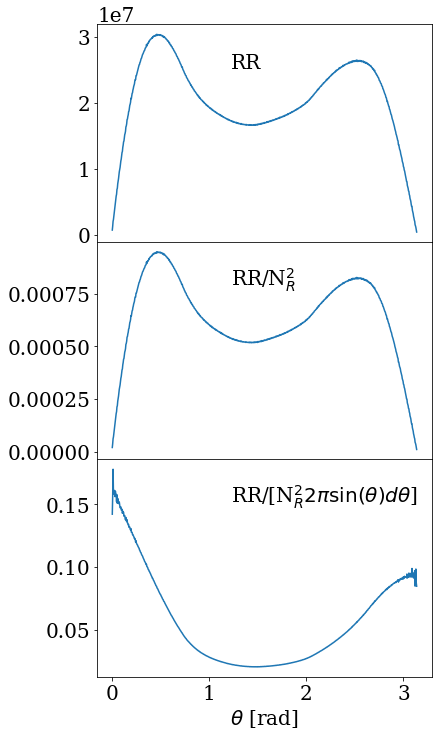

In [13]:
fig, ax = plt.subplots(nrows=3, figsize=(6, 12), sharex=True)
fig.subplots_adjust(hspace=0)
# 
ax[0].plot(xi_th.mid_sep, xi_th.rr)
ax[1].plot(xi_th.mid_sep, xi_th.rr/(xi_th.totalfrac**2))
ax[2].plot(xi_th.mid_sep, xi_th.rr/(2*np.pi*xi_th.totalfrac**2*np.sin(xi_th.mid_sep)*xi_th.dsep))
#ax[3].plot(xi_th.sep, xi_th.rr/(2*np.pi*xi_th.totalfrac**2*xi_th.sep*xi_th.dsep[0]))


for i, text_i in enumerate(['RR', r'RR/N$_{R}^{2}$', 
                            r'RR/[N$_{R}^{2} 2 \pi \sin(\theta)d\theta$]']):
    # r'RR/[N$_{R}^{2} 2 \pi \theta d\theta$]'
    ax[i].text(0.4, 0.8, text_i, transform=ax[i].transAxes)
    if i==0:
        ax[-1].set(xlabel=r'$\theta$ [rad]')

In [14]:
def poly(x, *params):
    x2 = x*x
    x3 = x2*x
    x4 = x2*x2
    x5 = x3*x2
    x6 = x5*x
    return params[0] + params[1]*x + params[2]*x2 + params[3]*x3 + params[4]*x4 + params[5]*x5 + params[6]*x6

x, y = xi_th.mid_sep, xi_th.rr/(2*np.pi*xi_th.totalfrac**2*np.sin(xi_th.mid_sep)*xi_th.dsep)
params,_ = curve_fit(poly, x, y, p0=[1, 1, 1, 1, 1, 1, 1])

In [15]:
sf = poly(x[0], *params)

(0, 1.2)

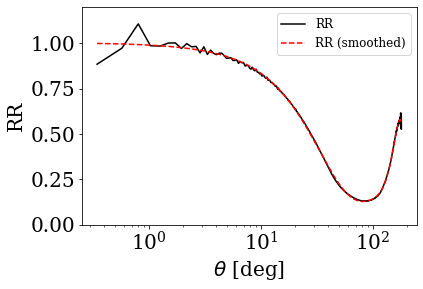

In [16]:
plt.plot(np.degrees(x), y/sf, 'k-',
         np.degrees(x), poly(x, *params)/sf, 'r--')
plt.legend(['RR', 'RR (smoothed)'], fontsize=12)
plt.xscale('log')
plt.ylabel('RR')
plt.xlabel(r'$\theta$ [deg]')
plt.ylim(0, 1.2)
# plt.xlim(xmin=0.1)

In [17]:
np.savetxt('./theta_omega_window.txt', np.column_stack([np.degrees(x), y/sf,  poly(x, *params)/sf]), 
          header='theta[deg], RR, RR [smoothed], *note* RR is normalized by 2piSin(theta)dtheta')

In [18]:
!head ./theta_omega_window.txt

# theta[deg], RR, RR [smoothed], *note* RR is normalized by 2piSin(theta)dtheta
3.435486411817406105e-01 8.850734451979475059e-01 1.000000000000000000e+00
5.725810686362342583e-01 9.736116986916774074e-01 9.968118421364375870e-01
8.016134960907280727e-01 1.107695775810464633e+00 9.935749168443932522e-01
1.030645923545221665e+00 9.869125220682873900e-01 9.902903155921601863e-01
1.259678350999715368e+00 9.853419546631313475e-01 9.869591187445722058e-01
1.488710778454209072e+00 1.001893031034369663e+00 9.835823956269951207e-01
1.717743205908702997e+00 1.002762135837954149e+00 9.801612045891517910e-01
1.946775633363196700e+00 9.720143045131914850e-01 9.766965930687782071e-01
2.175808060817690404e+00 9.987300537704206782e-01 9.731895976551154792e-01


In [19]:
sf

0.1606390792434416

In [20]:
(mask>0).sum()/mask.size

0.23623275756835938

In [25]:
xi_mod_intp   = IUS(cos_sep[::-1], xi_mod[::-1])
xg, wg        = np.polynomial.legendre.leggauss(5000)
xi_mod_wind   = xi_mod_intp(xg)*poly(np.arccos(xg), *params)/sf

In [26]:
1/(poly(np.arccos(xg), *params)/sf * wg).sum()

2.0186237925477477

In [27]:
cl_mod_wind   = xi2cl(xg, wg, xi_mod_wind, xg.size)

5001

Text(0, 0.5, 'C$_{\\ell}$')

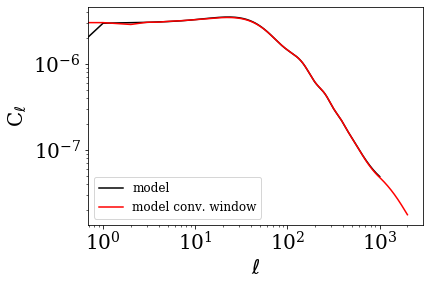

In [41]:
ell = np.arange(2000)
plt.figure(figsize=(6, 4))
plt.plot(np.arange(cl_mod.cl_mod.size), cl_mod.cl_mod, 'k-',
         ell, cl_mod_wind[ell], 'r-')
plt.loglog()
plt.legend(['model', 'model conv. window'], fontsize=12)
plt.xlabel(r'$\ell$')
plt.ylabel(r'C$_{\ell}$')


In [45]:
np.savetxt('./ell_cell_theory_window.txt', np.column_stack([ell, cl_mod.cl_mod[ell], cl_mod_wind[ell]]),
          header='ell - Cell - Cell window conv.')

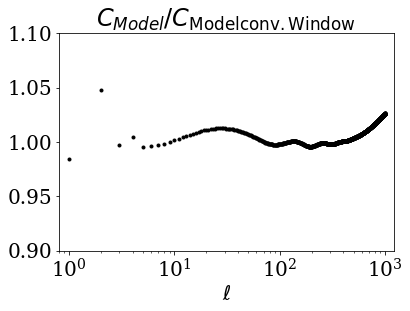

In [42]:
ell = np.arange(1001)
plt.figure(figsize=(6, 4))
plt.scatter(ell, cl_mod.cl_mod[ell]/cl_mod_wind[ell], color='k', marker='.')
plt.xlabel(r'$\ell$')
plt.title(r'$C_{Model}/C_{{\rm Model conv. Window}}$')
plt.xlim(0.8, 1200)
# plt.ylim(5.7, 6.3)
plt.ylim(0.9, 1.1)
plt.xscale('log')

In [197]:
cl_obs = np.load('/Volumes/TimeMachine/data/DR7/results/clustering/cl_nn_ab.npy', 
                allow_pickle=True).item()

In [254]:
frac = hp.read_map('/Volumes/TimeMachine/data/DR7/frac.hp.256.fits', verbose=False)
mask = hp.read_map('/Volumes/TimeMachine/data/DR7/mask.cut.hp.256.fits', verbose=False) > 0
frac[mask].sum()

179162.1875

In [259]:
mask1024 = hp.ud_grade(mask, nside_out=1024)
frac1024 = hp.ud_grade(frac, nside_out=1024)

In [260]:
hpfrac = hp.ma(frac1024)

In [261]:
hpfrac.mask=np.logical_not(mask1024>0)

/Users/rezaie/anaconda3/envs/py3p6/lib/python3.6/site-packages/healpy/projaxes.py:1196: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/Users/rezaie/anaconda3/envs/py3p6/lib/python3.6/site-packages/healpy/projaxes.py:1155: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):


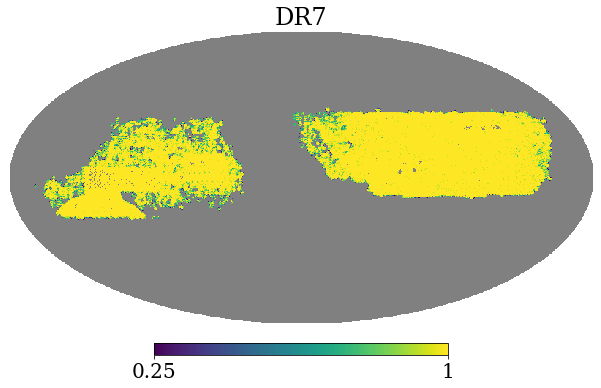

In [262]:
hp.mollview(hpfrac.filled(), rot=-89, title='DR7')

In [263]:
cl_win = hp.anafast(hpfrac.filled(), lmax=1024)

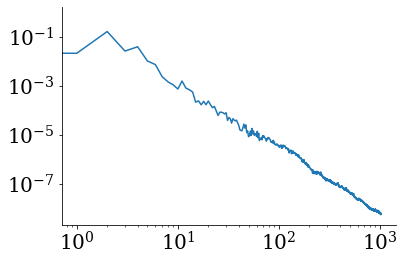

In [264]:
plt.loglog(cl_win)

In [265]:
xi_win = cl2xi(cl_win, cos_sep)

(0, 1)

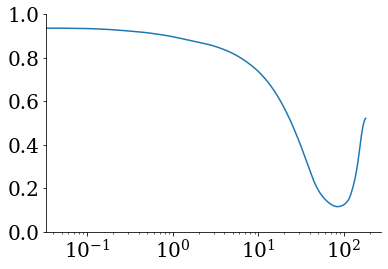

In [277]:
plt.plot(np.degrees(sep_rad), xi_win/0.23623275756835938)
plt.xscale('log')
plt.ylim(0, 1)

In [267]:
cl_obs_wind,_ = apply_window_v0(cl_obs['auto']*0.23429479830970087, sep_rad[::-1], xi_win[::-1]/0.23429479830970087, theory=False)

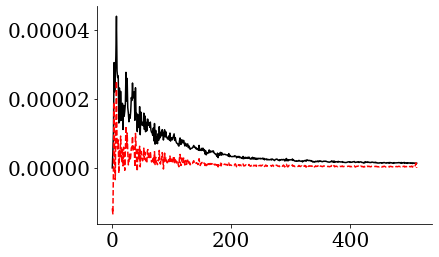

In [271]:
plt.plot(cl_obs['auto'], 'k-',
        cl_obs_wind, 'r--')
# plt.loglog()
# plt.ylim(1.e-9, 1.e-5)

In [273]:
mask.mean()

0.23623275756835938

In [ ]:
## uses Ashley's approach,
## does not allow multiple zero crossings

# import sys
# sys.path.append('/Users/rezaie/github/LSSanalysis')
# import legendre
# from time import time

# Leg = np.vectorize(legendre.legendre)
# x = np.linspace(-1.0, 1., 100, endpoint=True)
# c = np.zeros(5001)
# for j in [0, 1, 2]:
#     t1 = time()
#     y1 = scipyLeg(j, x)
#     t2 = time()
#     y2= Leg(j, x)
#     t3 = time()
#     plt.plot(x, y1, color='b', ls='-', alpha=0.5)
#     plt.plot(x, y2, color='r', ls=':')
#     print('scipy', t2-t1)
#     print('ashley', t3-t2)


# t     = np.linspace(0., 180., num=4*181, endpoint=True)
# cost  = np.cos(np.deg2rad(t))
# Omega = np.zeros(cost.size)

# elmax = 10000
# clmod = cl_mod.run(np.arange(elmax+10))

# fig, ax = plt.subplots(nrows=3, figsize=(10, 6), sharey=True,
#                       sharex=True)
# ls = ['-', '-.', '--']
# j = 0
# #for cr_limit in [500]:
# #    print(cr_limit)
# cr_limit=1.0e24
# for elmax_l in [10000]:#, 2000, 5000]:
#     for i,cost_i in enumerate(cost):
#         Omega[i] = 0.0
#         el     = 1
#         domega = 0.0
#         omega  = 0.0
#         cr     = 0
#         oldpl  = 1
#         while (cr <= cr_limit) & (el < elmax_l):
#             pl = scipyLeg(el, cost_i)
#             domega = (2*el+1)*pl*clmod[el]
#             #print(pl, oldpl)
#             #if (pl < 0) and (oldpl > 0):
#             #    cr += 1
#             el    += 1
#             omega += domega
#             oldpl  = pl
#         if i <3:print('i:{}, el:{}'.format(i, el))
#         Omega[i] = omega
#     Omega *= (0.25/np.pi)
#     ax[j].plot(t, Omega/1.0e-5, ls=ls[j], 
#                label='Lmax=%d'%elmax_l, color='k')
#              #label='# of zero crossing = %d'%cr_limit)
#     ax[j].text(0.7, 0.1, 'Lmax=%d'%elmax_l, color='k', transform=ax[j].transAxes)
#     ax[j].axhline(linestyle=':', color='grey')
#     j += 1
#     print('Sum Omega = {}'.format(sum(Omega*t)))
# # plt.ylim(-4.e-3, 6.e-3)
# ax[0].set(ylim=(-2.5, 1.2), title='Theoretical $\omega$')
# ax[2].set(xlabel=r'$\theta$ [deg]')
# ax[1].set(ylabel=r'$\omega$ [1e-5]')

In [308]:
cl_obs = np.load('/Volumes/TimeMachine/data/DR7/results/clustering/cl_nn_ab.npy', 
                allow_pickle=True).item()

In [309]:
cl_obs.keys()

dict_keys(['cross', 'auto', 'clerr', 'clabels', 'sf'])

In [310]:
cl_obs['sf']

0.23429479830970087

In [311]:
cl_wobs,_ = apply_window_v0(cl_obs['auto']*0.23429479830970087, xi_th.sep, xi_th.xiw, theory=False)

In [312]:
cl_wmod,_ = apply_window_v0(cl_mod.cl_mod, xi_th.sep, xi_th.xiw, theory=True)

[]

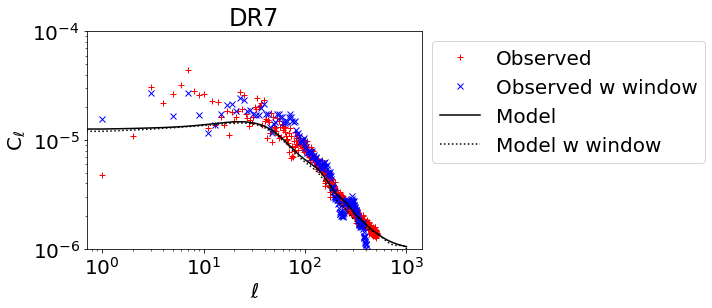

In [316]:
plt.plot(np.arange(cl_obs['auto'].size), cl_obs['auto'], marker='+', color='r', label='Observed', ls='None')
plt.plot(np.arange(cl_obs['auto'].size), cl_wobs*200,  marker='x', color='b', label='Observed w window', ls='None')

plt.plot(np.arange(cl_mod.cl_mod.size),  4*cl_mod.cl_mod  + 8.536537713893294e-07, 'k-',      label='Model')
plt.plot(np.arange(cl_wmod.size), 4*cl_wmod/720 + 8.536537713893294e-07, 'k:',      label='Model w window')
plt.ylim(1.e-6, 1.e-4)
plt.legend(bbox_to_anchor=(1., 1))
plt.title('DR7')
plt.xlabel(r'$\ell$')
plt.ylabel(r'C$_{\ell}$')
plt.loglog()
#plt.xlim(0.9, 1000)
# plt.yscale('log')